# Info

**Project**

Assessment of gap-filling techniques applied to satellite phytoplankton composition products for the Atlantic Ocean

**Credit**

© Ehsan Mehdipour (ehsan.mehdipour@awi.de)

Alfred Wegener Insitute for Polar and Marine Research, Bremerhaven, Germany


**Objective**

This code is using the separated validation and test dataset to evaluate the reconstruction performed by DINCAE gap-filling method.

**Dataset**

The dataset is accessable through Copernicus Marine Service with the following DOI:
https://doi.org/10.48670/moi-00280 and Dataset ID: cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D

# Setup and configuration

## Import modules

In [6]:
# Modules for data analysis
import os
os.environ["OMP_NUM_THREADS"] = "1"
import xarray as xr
import numpy as np
import pandas as pd
import dask

# Modules for data visualisation
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap
import matplotlib.dates as mdates
from matplotlib import gridspec
plt.rcParams['text.usetex'] = True
import cartopy.crs as ccrs
from cartopy.feature import LAND

# Miscellaneous modules
from tqdm import tqdm

# Manual modules or parameters
from function import *
from params import *

## Input and output parameters configuration

In [2]:
# CSV file detailing the boundries of regions of interest (ROI)
regions = pd.read_csv('data/regions.csv', index_col=0)

# Functions ( Cross-validation)

In [ ]:
def dev_CV(region, experiment_list, params):
    ''' 
    This function cross-validate all the experiments to assess the optimal model configuration
    
    Parameters:
    region (int): Number of the region to consider for development cross-validation
    experiment_list (list): List of int values with experiment number to consider for cross-validation analysis
    params (dict): Dictionary of parameters
    
    Returns:
    RMSLE_list (pd.dataframe): list of the RMSLE values for all experiments for development region
    '''
    
    # Read Input data
    cloud_date_train = pd.read_csv(os.path.join(params['output_dir'], str(region), f'cloud_date_train.csv'))
    
    ## Read development data
    ds_dev = xr.open_dataset(os.path.join(params['output_dir'], str(region), 'ds_pft_dev.nc'),chunks='auto')
    time = ds_dev.time
    ds_dev = ds_dev[params['PFT']]
    ds_dev = ds_dev.sel(time=cloud_date_train.clouded_date.values).compute()
    ds_dev = rm_boundry(ds_dev)
    
    ## Read training data
    ds_train = xr.open_dataset(os.path.join(params['output_dir'], str(region), f'ds_pft_train.nc'),chunks='auto')
    ds_train = ds_train[params['PFT']]
    ds_train = ds_train.sel(time=cloud_date_train.clouded_date.values).compute()
    ds_train = rm_boundry(ds_train)

    # Create mask of the development dataset
    mask = np.isfinite(ds_dev) & np.isnan(ds_train)
    # mask = mask.where(mask==True, drop=True)
    
    ## Cross-validation and RMSLE computation
    RMSLE_list = []
    for experiment in tqdm(experiment_list):
        
        ## Read DINCAE dataset
        ds_dincae = xr.open_dataset(os.path.join(params['output_dir'], str(region), f'DINCAE/{experiment}/ds_reconstructed.nc'))
        ds_dincae = ds_dincae.assign_coords({'time':time})
        ds_dincae = ds_dincae[params['PFT']]
        ds_dincae = ds_dincae.sel(time=cloud_date_train.clouded_date.values).compute()
        ds_dincae = rm_boundry(ds_dincae)
        
        ## Logarithmic Error
        LogErr = (ds_dincae - ds_dev).where(mask)
        
        ## RMSLE computation
        RMSLE = np.sqrt(np.mean(np.square(LogErr)))
        RMSLE['Total'] = np.sqrt(np.mean(np.square(LogErr.to_array())))
        RMSLE_df = RMSLE.to_array('PFT').rename(experiment).to_dataframe()
        # RMSLE_df.to_csv(os.path.join(params['output_dir'], str(region), f'DINCAE/RMSLE/{experiment}.csv'))
        RMSLE_list.append(RMSLE_df)

        ds_dincae.close()
    ## concatenate the list and sorting
    RMSLE_list = pd.concat(RMSLE_list, axis=1)
    RMSLE_list = RMSLE_list.T.sort_values(by='Total').T
    return RMSLE_list

In [ ]:
def test_CV(region, experiment_list, params):
    ''' 
    This function do a cross-validation with all the test dataset 
    and final experiment to assess final model error with independet dataset
    
    Parameters:
    region (int): Number of the region to consider for cross-validation
    experiment_list (list): List containing final experiment extension file name
    params (dict): Dictionary of parameters
    
    Returns:
    RMSLE_list (pd.dataframe): list of the RMSLE for final experiment on all regions
    MAPE_list (pd.dataframe): list of the MAPE for final experiment on all regions
    MdAPE_list (pd.dataframe): list of the MdAPE for final experiment on all regions
    '''
    
     # Read Input data
    cloud_date_dev = pd.read_csv(os.path.join(params['output_dir'], str(region), f'cloud_date_dev.csv'))
    
    ## Read development data
    ds_dev = xr.open_dataset(os.path.join(params['output_dir'], str(region), f'ds_pft_dev.nc'),chunks='auto')
    time = ds_dev.time
    ds_dev = ds_dev[params['PFT']]
    ds_dev = ds_dev.sel(time=cloud_date_dev.clouded_date.values).compute()
    ds_dev = rm_boundry(ds_dev)

    ## Read test data
    ds_test = xr.open_dataset(os.path.join(params['output_dir'], str(region), 'ds_pft.nc'),chunks='auto')
    ds_test = ds_test[params['PFT']]
    ds_test = ds_test.sel(time=cloud_date_dev.clouded_date.values).compute()
    ds_test = rm_boundry(ds_test)
    
    ## Create mask of the development dataset
    mask = np.isfinite(ds_test) & np.isnan(ds_dev)
    # mask = mask.where(mask==True, drop=True)
    
    ## Cross-validation statistics computation
    RMSLE_list = []
    MAPE_list = []
    MdAPE_list = []
    
    for experiment in experiment_list:
        ## Read DINCAE dataset
        ds_dincae = xr.open_dataset(os.path.join(params['output_dir'], str(region), f'DINCAE/{experiment}/ds_reconstructed.nc'))
        ds_dincae = ds_dincae.assign_coords({'time':time})
        ds_dincae = ds_dincae[params['PFT']]
        ds_dincae = ds_dincae.sel(time=cloud_date_dev.clouded_date.values).compute()
        ds_dincae = rm_boundry(ds_dincae)
        
        ## Logarithmic Error
        LogErr = (ds_dincae - ds_test).where(mask)

        # RMSLE computation
        RMSLE = np.sqrt(np.mean(np.square(LogErr)))
        RMSLE['Total'] = np.sqrt(np.mean(np.square(LogErr.to_array())))
        RMSLE_df = RMSLE.to_array('PFT').rename(experiment).to_dataframe()
        RMSLE_list.append(RMSLE_df)
                
        ## Linear Error
        LinErr = ((10**ds_dincae) - (10**ds_test)).where(mask)
        
        # MAPE computation
        MAPE = (abs(LinErr/(10**ds_test)))
        MAPE['Total'] = (abs(LinErr/(10**ds_test)).to_array())
        MAPE = MAPE.where(MAPE<100) # Outlier Removal
        MAPE = MAPE.mean() * 100
        MAPE_df = MAPE.to_array('PFT').rename(experiment).to_dataframe()
        MAPE_list.append(MAPE_df)
        
        # MdAPE computation
        MdAPE = (abs(LinErr/(10**ds_test))).median() * 100
        MdAPE['Total'] = (abs(LinErr/(10**ds_test)).to_array()).median() * 100
        MdAPE_df = MdAPE.to_array('PFT').rename(experiment).to_dataframe()
        MdAPE_list.append(MdAPE_df)
    
    return RMSLE_list, MAPE_list , MdAPE_list

# Call

## Development

In [ ]:
# Run the cross-validation over all experiments during the development phase

## Region to consider for development (validation) purposes
region = 9

## List of experiments to compute the cross-validation to evaluate
## the optimal configuration during development phase
experiment_list = list(range(1,111))

RMSLE_list = dev_CV(region=region, experiment_list=experiment_list, params=params)
RMSLE_list
# RMSLE_list.to_csv(os.path.join(params['output_dir'],f'{region}/DINCAE/RMSLE/dev_RMSLE.csv')

## Test

In [ ]:
# Run the cross-validation over all regions during the test phase
experiment_list = ['final']


RMSLE_all = []
MAPE_all = []
MdAPE_all = []
index = list(regions.index)

for region in tqdm(index):
    RMSLE_list, MAPE_list , MdAPE_list = test_CV(region, experiment_list, params)
    
    RMSLE_list = pd.concat(RMSLE_list, axis=1)
    MAPE_list = pd.concat(MAPE_list, axis=1)
    MdAPE_list = pd.concat(MdAPE_list, axis=1)
    
    RMSLE_all.append(RMSLE_list)
    MAPE_all.append(MAPE_list)
    MdAPE_all.append(MdAPE_list)
    
RMSLE_all = pd.concat(RMSLE_all, axis=1)
MAPE_all = pd.concat(MAPE_all, axis=1)
MdAPE_all = pd.concat(MdAPE_all, axis=1)

### Save the results to CSV files

In [ ]:
RMSLE = RMSLE_all.T
RMSLE.index = index
RMSLE = RMSLE.round(3)
RMSLE.to_csv('data/CV_stat/dincae_RMSLE.csv')
RMSLE

In [ ]:
MAPE = MAPE_all.T
MAPE.index = index
MAPE = MAPE.round(1)
MAPE.to_csv('data/CV_stat/dincae_MAPE.csv')
MAPE

In [ ]:
MdAPE = MdAPE_all.T
MdAPE.index = index
MdAPE = MdAPE.round(1)
MdAPE.to_csv('data/CV_stat/dincae_MdAPE.csv')
MdAPE

# Error distribution

### Function

In [3]:
def error_analysis(region, experiment_list, params):
    ''' 
    This function compute the average cross-validation error in each pixels.
    
    Parameters:
    region (int): Number of the region to consider for development cross-validation
    experiment_list (list): List of int values with experiment number to consider for cross-validation analysis
    params (dict): Dictionary of parameters
    
    Returns:
    LogErr (xr.Dataset): Dataset showing the logarithmic difference between the test and DINCAE reconstruction
    ds_test (xr.Dataset): Test dataset
    ds_dincae (xr.Dataset): DINCAE reconstruction dataset
    '''
     # Read Input data
    cloud_date_dev = pd.read_csv(os.path.join(params['output_dir'], str(region), f'cloud_date_dev.csv'))
    
    ## Read development dataset
    ds_dev = xr.open_dataset(os.path.join(params['output_dir'], str(region), f'ds_pft_dev.nc'),chunks='auto')
    time = ds_dev.time
    ds_dev = ds_dev[params['PFT']]
    ds_dev = ds_dev.sel(time=cloud_date_dev.clouded_date.values).compute()
    ds_dev = rm_boundry(ds_dev)
    
    ## Read test dataset
    ds_test = xr.open_dataset(os.path.join(params['output_dir'], str(region), 'ds_pft.nc'),chunks='auto')
    ds_test = ds_test[params['PFT']]
    ds_test = ds_test.sel(time=cloud_date_dev.clouded_date.values).compute()
    ds_test = rm_boundry(ds_test)
    
    ## Compute the mask
    mask = np.isfinite(ds_test) & np.isnan(ds_dev)
    # mask = mask.where(mask==True, drop=True)
    
    ## Final reconstruction
    for experiment in experiment_list:
        
        ## Read DINCAE reconstructed dataset
        ds_dincae = xr.open_dataset(os.path.join(params['output_dir'], str(region), f'DINCAE/{experiment}/ds_reconstructed.nc'))
        ds_dincae = ds_dincae.assign_coords({'time':time})
        ds_dincae = ds_dincae[params['PFT']]
        ds_dincae = ds_dincae.sel(time=cloud_date_dev.clouded_date.values).compute()
        ds_dincae = rm_boundry(ds_dincae)
        
        ## Computing the logarithmic difference for the cross-validation locations
        LogErr = (ds_dincae - ds_test).where(mask)
        
    return LogErr, ds_test , ds_dincae

### Call

In [4]:
## Considering the final reconstruction for all regions
experiment_list = ['final']

## Looping through all regions to attached the error datasets together
LogErr_list = []
for i in tqdm(range(1,11)):
    LogErr, ds_test , ds_dincae = error_analysis(i, experiment_list, params)
    LogErr_mean = abs(LogErr).mean(dim='time')
    LogErr_list.append(LogErr_mean)
ds = xr.combine_nested(LogErr_list, compat='override',coords='all', concat_dim=['time'])
error_mean = ds.mean(dim='time')

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:33<00:00,  9.40s/it]


### Plot

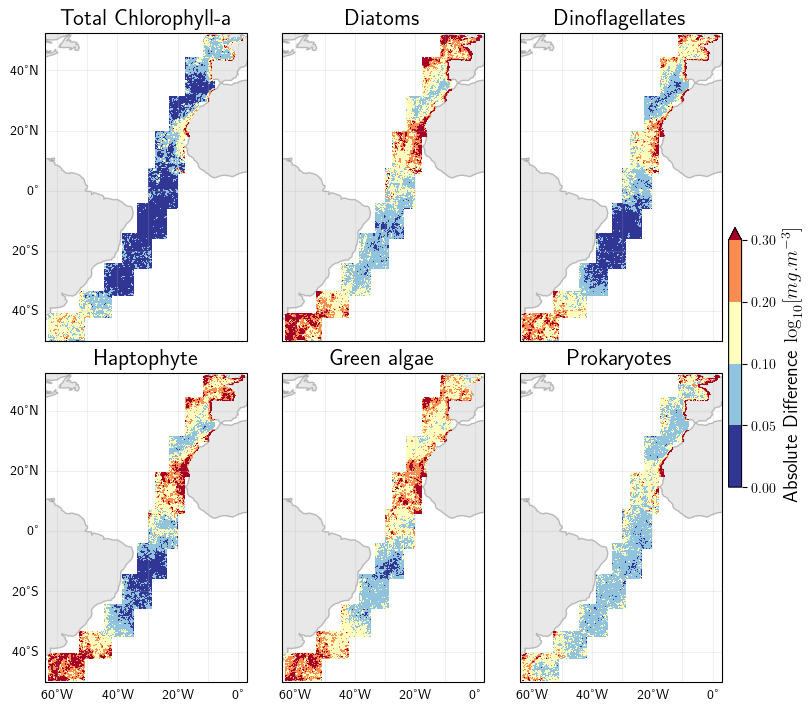

In [9]:
cbar_levels = [0,0.05,0.1,0.2,0.3]
fig, ax = plt.subplots(2,3,figsize=(8,7), constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})
ax = ax.flatten()

for i, p in enumerate(params['PFT']):
    plot1 = error_mean[p].plot.contourf(ax=ax[i],transform=ccrs.PlateCarree(), levels= cbar_levels, cmap='RdYlBu_r',add_colorbar=False)
    ax[i].set_title(params['PFT_longname'][p], fontsize=16)
    ax[i].add_feature(LAND, facecolor='lightgrey', edgecolor='grey', alpha=0.5)
    gl = ax[i].gridlines(draw_labels=True,alpha=0.2, linestyle='-')
    gl.right_labels = False
    gl.top_labels = False
    if i<3:
        gl.bottom_labels=False
    if i not in [0,3]:
        gl.left_labels=False
    ax[i].set_extent([-64,3,-45,47.5])
    
cbar = fig.colorbar(plot1, ax=ax[:], orientation='vertical', shrink=0.4, pad=0.01)
cbar.set_label(r'Absolute Difference $\log_{10}[mg.m^{-3}]$', fontsize=14)

# plt.savefig('fig/error_map_dincae_absolute_difference.png', dpi=600, bbox_inches='tight')